/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 43s 116ms/step - accuracy: 0.6037 - loss: 1.3410 - val_accuracy: 0.8172 - val_loss: 0.5650
Epoch 2/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 42s 116ms/step - accuracy: 0.8377 - loss: 0.5511 - val_accuracy: 0.8595 - val_loss: 0.4629
Epoch 3/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.8738 - loss: 0.4372 - val_accuracy: 0.8790 - val_loss: 0.3986
Epoch 4/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 44s 122ms/step - accuracy: 0.8911 - loss: 0.3695 - val_accuracy: 0.8848 - val_loss: 0.3675
Epoch 5/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.8982 - loss: 0.3355 - val_accuracy: 0.8998 - val_loss: 0.3421
Epoch 6/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.9048 - loss: 0.3175 - val_accuracy: 0.8987 - val_loss: 0.3063
Epoch 7/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.9120 - loss: 0.2813 - val_accuracy: 0.9024 - val_loss: 0.3040
Epoch 8/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.9175 - loss: 0

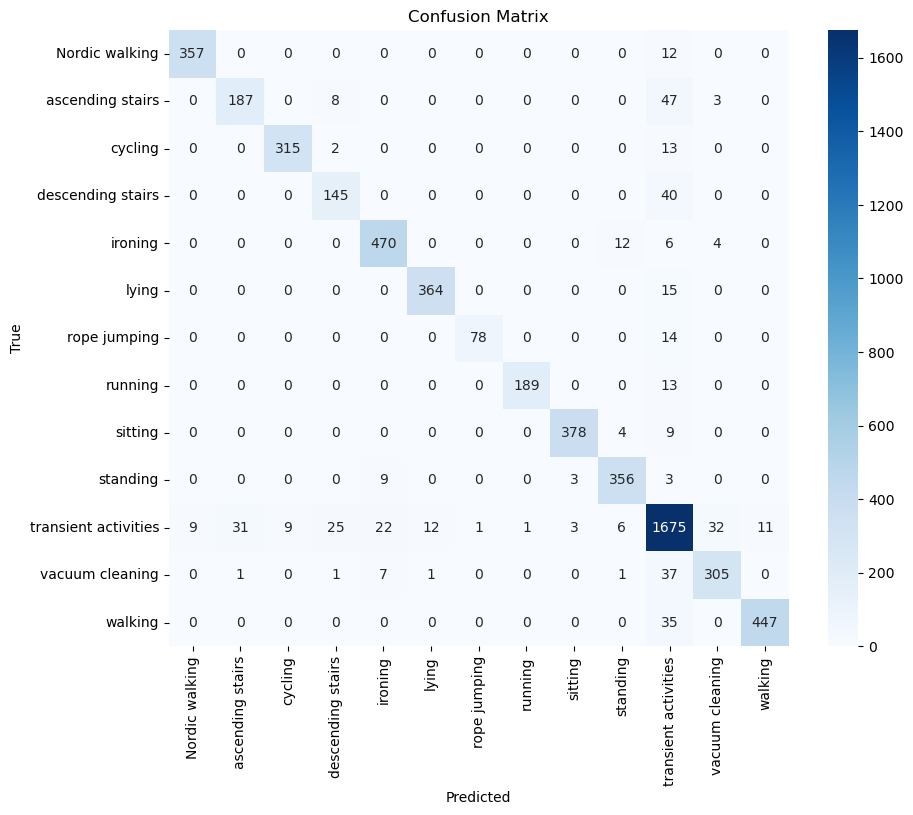

                      precision    recall  f1-score   support

      Nordic walking       0.98      0.97      0.97       369
    ascending stairs       0.85      0.76      0.81       245
             cycling       0.97      0.95      0.96       330
   descending stairs       0.80      0.78      0.79       185
             ironing       0.93      0.96      0.94       492
               lying       0.97      0.96      0.96       379
        rope jumping       0.99      0.85      0.91        92
             running       0.99      0.94      0.96       202
             sitting       0.98      0.97      0.98       391
            standing       0.94      0.96      0.95       371
transient activities       0.87      0.91      0.89      1837
     vacuum cleaning       0.89      0.86      0.88       353
             walking       0.98      0.93      0.95       482

            accuracy                           0.92      5728
           macro avg       0.93      0.91      0.92      5728
      

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load the dataset
data = pd.read_csv('dataset2.csv')

# Handle missing values (if any)
data = data.dropna()

# Feature selection
# Assuming 'activity' is the target variable and others are features
features = data.drop(columns=['activityID'])
labels = data['activityID']

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Reshape features to 3D for LSTM [samples, timesteps, features]
# Assuming each activity sequence is of length 100 timesteps
timesteps = 100
num_features = features_scaled.shape[1]
X = []
y = []
for i in range(0, len(features_scaled) - timesteps, timesteps):
    X.append(features_scaled[i:i + timesteps])
    y.append(labels_categorical[i + timesteps - 1])  # Use the last label in the sequence

X = np.array(X)
y = np.array(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features), return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=50, batch_size=64, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
class_report = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)
print(class_report)

